In [1]:
import os
import sys
import json
import math
import torch
import numpy as np

import matplotlib
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    # 'font.family': 'serif',
    'font.size':12,
})
from matplotlib import pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
seed_everything(42)

import DiffNet
from DiffNet.networks.wgan import GoodNetwork
from DiffNet.networks.wgan_old import GoodGenerator
from DiffNet.networks.autoencoders import AE
from DiffNet.DiffNetFEM import DiffNet2DFEM
from DiffNet.datasets.single_instances.rectangles import RectangleManufactured

from pytorch_lightning.callbacks.base import Callback

Global seed set to 42


In [2]:
class OptimSwitchLBFGS(Callback):
    def __init__(self, epochs=10):
        self.switch_epoch = epochs

    def on_epoch_start(self, trainer, pl_module):
        if trainer.current_epoch == self.switch_epoch:
            opts = [torch.optim.LBFGS(pl_module.network.parameters(), lr=1.0, max_iter=10)]
            trainer.optimizers = opts

In [3]:
class Poisson(DiffNet2DFEM):
    """docstring for Poisson"""
    def __init__(self, network, dataset, **kwargs):
        super(Poisson, self).__init__(network, dataset, **kwargs)
        x = np.linspace(0,1,self.domain_size)
        y = np.linspace(0,1,self.domain_size)
        xx, yy = np.meshgrid(x,y)
        self.u_exact = torch.tensor(self.exact_solution(xx,yy))

    def exact_solution(self, x,y):
        return np.sin(math.pi*x)*np.sin(math.pi*y)

    def loss(self, u, inputs_tensor, forcing_tensor):

        f = forcing_tensor # renaming variable
        
        # extract diffusivity and boundary conditions here
        nu = inputs_tensor[:,0:1,:,:]
        bc1 = inputs_tensor[:,1:2,:,:]
        bc2 = inputs_tensor[:,2:3,:,:]

        # apply boundary conditions
        u = torch.where(bc1>0.5,1.0+u*0.0,u)
        u = torch.where(bc2>0.5,u*0.0,u)


        nu_gp = self.gauss_pt_evaluation(nu)
        f_gp = self.gauss_pt_evaluation(f)
        u_gp = self.gauss_pt_evaluation(u)
        u_x_gp = self.gauss_pt_evaluation_der_x(u)
        u_y_gp = self.gauss_pt_evaluation_der_y(u)

        transformation_jacobian = self.gpw.unsqueeze(-1).unsqueeze(-1).unsqueeze(0).type_as(nu_gp)
        res_elmwise = (transformation_jacobian * (0.5 * nu_gp * (u_x_gp**2 + u_y_gp**2) - (u_gp * f_gp)))
        res_elmwise = torch.sum(res_elmwise, 1) 

        loss = torch.mean(res_elmwise)
        return loss

    def forward(self, batch):
        inputs_tensor, forcing_tensor = batch
        # print("size of inputs_tensor = ", inputs_tensor.shape)
        # print("size of forcing_tensor = ", forcing_tensor.shape)
        # exit()
        return self.network(inputs_tensor), inputs_tensor, forcing_tensor

    # def configure_optimizers(self):
    #     """
    #     Configure optimizer for network parameters
    #     """
    #     lr = self.learning_rate
    #     opts = [torch.optim.Adam(self.network, lr=lr)]
    #     return opts, []

    # def training_step(self, batch, batch_idx, optimizer_idx):
    # # def training_step(self, batch, batch_idx):
    #     if self.current_epoch % 2:
    #         opt = 1
    #     else:
    #         opt = 0
    #     if optimizer_idx==opt:
    #         u, inputs_tensor, forcing_tensor = self.forward(batch)
    #         loss_val = self.loss(u, inputs_tensor, forcing_tensor).mean()
    #         # self.log('PDE_loss', loss_val.item())
    #         # self.log('loss', loss_val.item())
    #     else:
    #         loss_val = torch.zeros((1), requires_grad=True)
    #     return {"loss": loss_val}

    def training_step(self, batch, batch_idx):
    # def training_step(self, batch, batch_idx):
        u, inputs_tensor, forcing_tensor = self.forward(batch)
        loss_val = self.loss(u, inputs_tensor, forcing_tensor).mean()
        # self.log('PDE_loss', loss_val.item())
        # self.log('loss', loss_val.item())
        return {"loss": loss_val}

    def training_step_end(self, training_step_outputs):
        loss = training_step_outputs["loss"]
        return training_step_outputs

    def configure_optimizers(self):
        lr = self.learning_rate

        opts = [torch.optim.Adam(self.network.parameters(), lr=lr)]

        # opts = [torch.optim.Adam(self.network, lr=lr), torch.optim.LBFGS(self.network, lr=1.0, max_iter=5)]
        schd = [torch.optim.lr_scheduler.ExponentialLR(opts[0], gamma=0.95)]
        return opts, schd
    
    def do_query(self, inputs, forcing):
        u, inputs_tensor, forcing_tensor = self.forward((inputs.unsqueeze(0).type_as(next(self.network.parameters())), 
                                                         forcing.unsqueeze(0).type_as(next(self.network.parameters()))))
        
        f = forcing_tensor.squeeze().detach().cpu() # renaming variable
        
        # extract diffusivity and boundary conditions here
        nu = inputs_tensor[:,0:1,:,:]
        bc1 = inputs_tensor[:,1:2,:,:]
        bc2 = inputs_tensor[:,2:3,:,:]        
        # process diffusivity
        k = nu.squeeze().detach().cpu()

        # process u (by adding BC)
        u = torch.where(bc1>0.5,1.0+u*0.0,u)
        u = torch.where(bc2>0.5,u*0.0,u)        
        u = u.squeeze().detach().cpu()
        
        return u, k, f
    
    def plot_contours(self,k,f,u,u_exact):
        diff = u - u_exact
        # plotting        
        fig, axs = plt.subplots(1, 5, figsize=(3*5,2),
                            subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
        for ax in axs:
            ax.set_xticks([])
            ax.set_yticks([])              
        
        # print(np.linalg.norm(diff.flatten())/self.domain_size)
        im = axs[0].imshow(f,cmap='jet')
        fig.colorbar(im, ax=axs[0], ticks=[0.0, 4.0, 8.0, 12.0, 16.0, 20.0]); axs[0].set_title(r'$f$')
        im = axs[1].imshow(k,cmap='jet')
        fig.colorbar(im, ax=axs[1]); axs[1].set_title(r'$\nu$')
        im = axs[2].imshow(u,cmap='jet', vmin=0.0, vmax=1.0)
        fig.colorbar(im, ax=axs[2]); axs[2].set_title(r'$u_{\theta}$')
        im = axs[3].imshow(u_exact,cmap='jet', vmin=0.0, vmax=1.0)
        fig.colorbar(im, ax=axs[3]); axs[3].set_title(r'$u_{exact}$')
        im = axs[4].imshow(diff,cmap='jet')
        fig.colorbar(im, ax=axs[4]); axs[4].set_title(r'$u_{\theta}-u_{exact}$')
        plt.show()
        # plt.savefig(os.path.join(self.logger[0].log_dir, 'contour_' + str(self.current_epoch) + '.png'))
        # self.logger[0].experiment.add_figure('Contour Plots', fig, self.current_epoch)
        # plt.close('all')        

    def on_epoch_end(self):
        self.network.eval()
        inputs, forcing = self.dataset[0]
        u, k, f = self.do_query(inputs, forcing)                
        
        u_exact = self.u_exact.squeeze().detach().cpu()
        diff = u - u_exact
        
        self.plot_contours(k,f,u,u_exact)

/miniconda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7fd617768e50>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7fd617768e50>)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/miniconda/lib/python3.7/site-packages/pytorch_lightning/loggers/csv_logs.py:58: UserWarning: Experiment logs directory ./mms-network/version_1 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  f"Experiment logs directory {self.log_dir} exists and is not empty."

  | Name      |

Epoch 0: 100%|██████████| 100/100 [06:54<00:00,  4.14s/it, loss=-9.66, v_num=1_1]

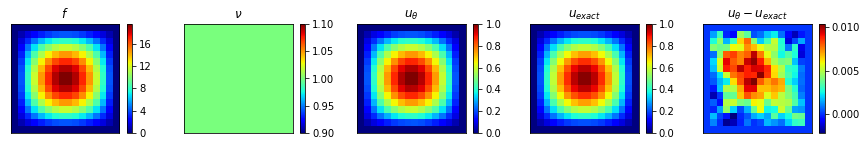

Epoch 1: 100%|██████████| 100/100 [09:57<00:00,  5.97s/it, loss=-9.69, v_num=1_1]

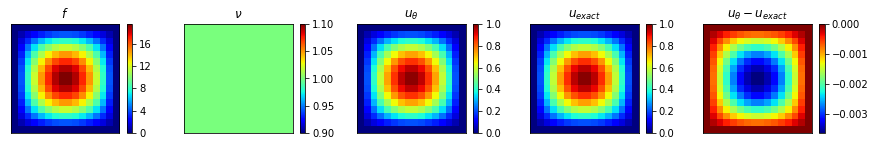

Epoch 2: 100%|██████████| 100/100 [06:48<00:00,  4.08s/it, loss=-9.69, v_num=1_1]

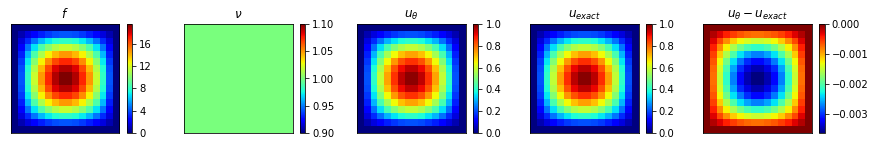

Epoch 3: 100%|██████████| 100/100 [06:50<00:00,  4.10s/it, loss=-9.69, v_num=1_1]

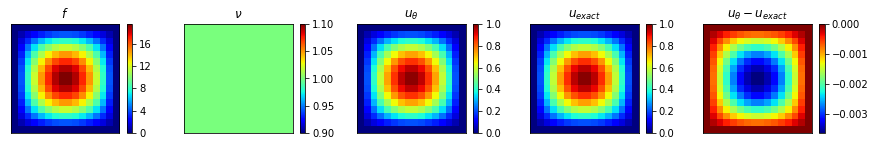

Epoch 4: 100%|██████████| 100/100 [06:28<00:00,  3.89s/it, loss=-9.69, v_num=1_1]

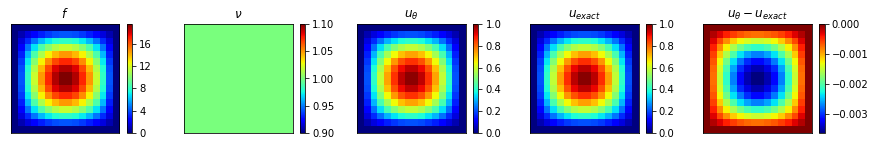

Epoch 4: 100%|██████████| 100/100 [06:45<00:00,  4.06s/it, loss=-9.69, v_num=1_1]


FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  2296.8         	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  459.11         	|5              	|  2295.5         	|  99.945         	|
run_training_batch                 	|  4.407          	|500            	|  2203.5         	|  95.938         	|
optimizer_step_with_closure_0      	|  4.4059         	|500            	|  2202.9         	|  95.914         	|
training_step_and_backward         	|  2.2668         	|534            	|  1210.4         	|  52.701         	|
model_forward                      

In [5]:
domain_size = 16

u_tensor = np.ones((1,1,domain_size,domain_size))
network = AE(in_channels=3, out_channels=1, dims=16, n_downsample=3)
# network = GoodNetwork(in_channels=3, out_channels=1, in_dim=domain_size, out_dim=domain_size, lowest_dim=4, filters=32)
# network = GoodGenerator()
dataset = RectangleManufactured(domain_size=domain_size)
basecase = Poisson(network, dataset, batch_size=1, domain_size=domain_size, learning_rate=3e-4)

# ------------------------
# 1 INIT TRAINER
# ------------------------
logger = pl.loggers.TensorBoardLogger('.', name="mms-network")
csv_logger = pl.loggers.CSVLogger(logger.save_dir, name=logger.name, version=logger.version)

checkpoint = pl.callbacks.model_checkpoint.ModelCheckpoint(monitor='loss',
    dirpath=logger.log_dir, filename='{epoch}-{step}',
    mode='min', save_last=True)

lbfgs_switch = OptimSwitchLBFGS(epochs=1)

trainer = Trainer(callbacks=[lbfgs_switch],
    checkpoint_callback=checkpoint, precision=64, logger=[logger,csv_logger],
    max_epochs=5, deterministic=True, profiler="simple")

# ------------------------
# 4 Training
# ------------------------

trainer.fit(basecase)

# ------------------------
# 5 SAVE NETWORK
# ------------------------
torch.save(basecase.network, os.path.join(logger.log_dir, 'network.pt'))

J =  0.0011111111111111111
usol.shape = (16, 16)
uex.shape = (16, 16)
||u_sol||, ||uex|| =  0.49454496145744103 0.4999999999999998
||e||_{{L2}} =  0.005456027405919965
||e|| (vector-norm) =  0.0017121349800275193


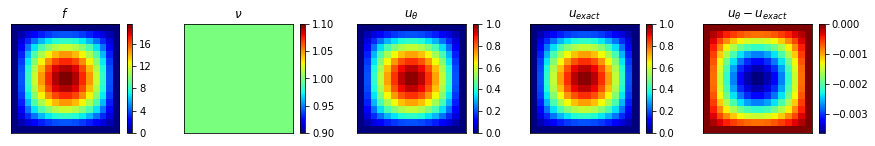

In [5]:
# Query
basecase.dataset[0]
inputs, forcing = basecase.dataset[0]
u, k, f = basecase.do_query(inputs, forcing) 
u_exact = basecase.u_exact.squeeze().detach().cpu()
# L2 error calculation
basecase.calc_l2_err(u.numpy())
# plot
basecase.plot_contours(k,f,u,u_exact)